In [1]:
import dask
dask.config.set({'dataframe.query-planning': False})

import numpy as np
from pathlib import Path
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.extend(['../../scripts','../../scripts/xenium'])
import readwrite
cfg = readwrite.config()

def diagonal_line(ax):
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    min_val, max_val = np.max(limits[:, 0]), np.min(limits[:, 1])  # Get the valid range in log scale
    ax.plot([min_val, max_val], [min_val, max_val], c='k', lw=1, alpha=0.8, zorder=1)

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error a

## Load data

In [2]:
# cfg paths
xenium_dir = Path(cfg['xenium_processed_data_dir'])
xenium_raw_data_dir = Path(cfg['xenium_raw_data_dir'])
results_dir = Path(cfg['results_dir'])

# Segmentation, mapping paths
dir_segmentations = {
    dir_segmentation.name: (dir_segmentation)
    for dir_segmentation in xenium_dir.iterdir()
}
# dir_segmentations['default'] = xenium_raw_data_dir

# Read resegmentations and RCTD
xenium_paths = {}
umaps = {}

for segmentation in (segmentations := xenium_dir.iterdir()):
    if segmentation.stem not in ['10x_0um']:
        continue
    for condition in (conditions := segmentation.iterdir()): 
        if condition.stem not in ['breast']:
            continue
        for panel in (panels := condition.iterdir()):
            for donor in (donors := panel.iterdir()):
                for sample in (samples := donor.iterdir()):
                    
                    k = (segmentation.stem,condition.stem,panel.stem,donor.stem,sample.stem)

                    if segmentation.stem == 'proseg':
                        sample_path = sample / 'raw_results'
                    else:
                        sample_path = sample / "normalised_results/outs"
                    name = '/'.join(k)

                    xenium_paths[k] = sample_path
                    # if (sample_path / 'analysis/umap/gene_expression_2_components/projection.csv').exists():
                    #     umaps[k] = pd.read_csv(sample_path / 'analysis/umap/gene_expression_2_components/projection.csv',index_col=0)


xenium_levels = ('segmentation','condition','panel','donor','sample')
ads = readwrite.read_xenium_samples(xenium_paths,anndata=True,transcripts=False)
ads = pd.Series(ads.values(),
                index=pd.Index(ads.keys(),name = xenium_levels),
                dtype=object).sort_index()

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/OPHI/OPHI_1/normalised_results/outs/cell_feature_matrix.h5                                          
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/OPHI/OPHI_3/normalised_results/outs/cell_feature_matrix.h5                                          
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/0U9A/0U9A/normalised_results/outs/cell_feature_matrix.h5 

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is an

In [3]:
u_condition_panel = ads.index.to_frame()[['condition','panel']].drop_duplicates().index

# load probe count info
gene_panels_info = {}
for condition_panel in u_condition_panel:
    condition, panel = condition_panel[1:3]
    name = '/'.join(condition_panel)
    p=f'/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/{name}/normalised_results/outs/gene_panel.json'
    gene_panels_info[condition, panel] = readwrite.get_gene_panel_info(p)

In [21]:
ad = ads.iloc[0]
n_probes = (gene_panels_info[condition, panel] 
        .set_index('name')['gene_coverage'] 
        .loc[ad.var_names])


# divide expression by number of probes
X_normalised = ad.to_df()/n_probes

# get just one gene
g = 'ABCC11'
y = ad[:,g].X.toarray().flatten()
x = n_probes[g]

## Xenium n° probes vs mean expr

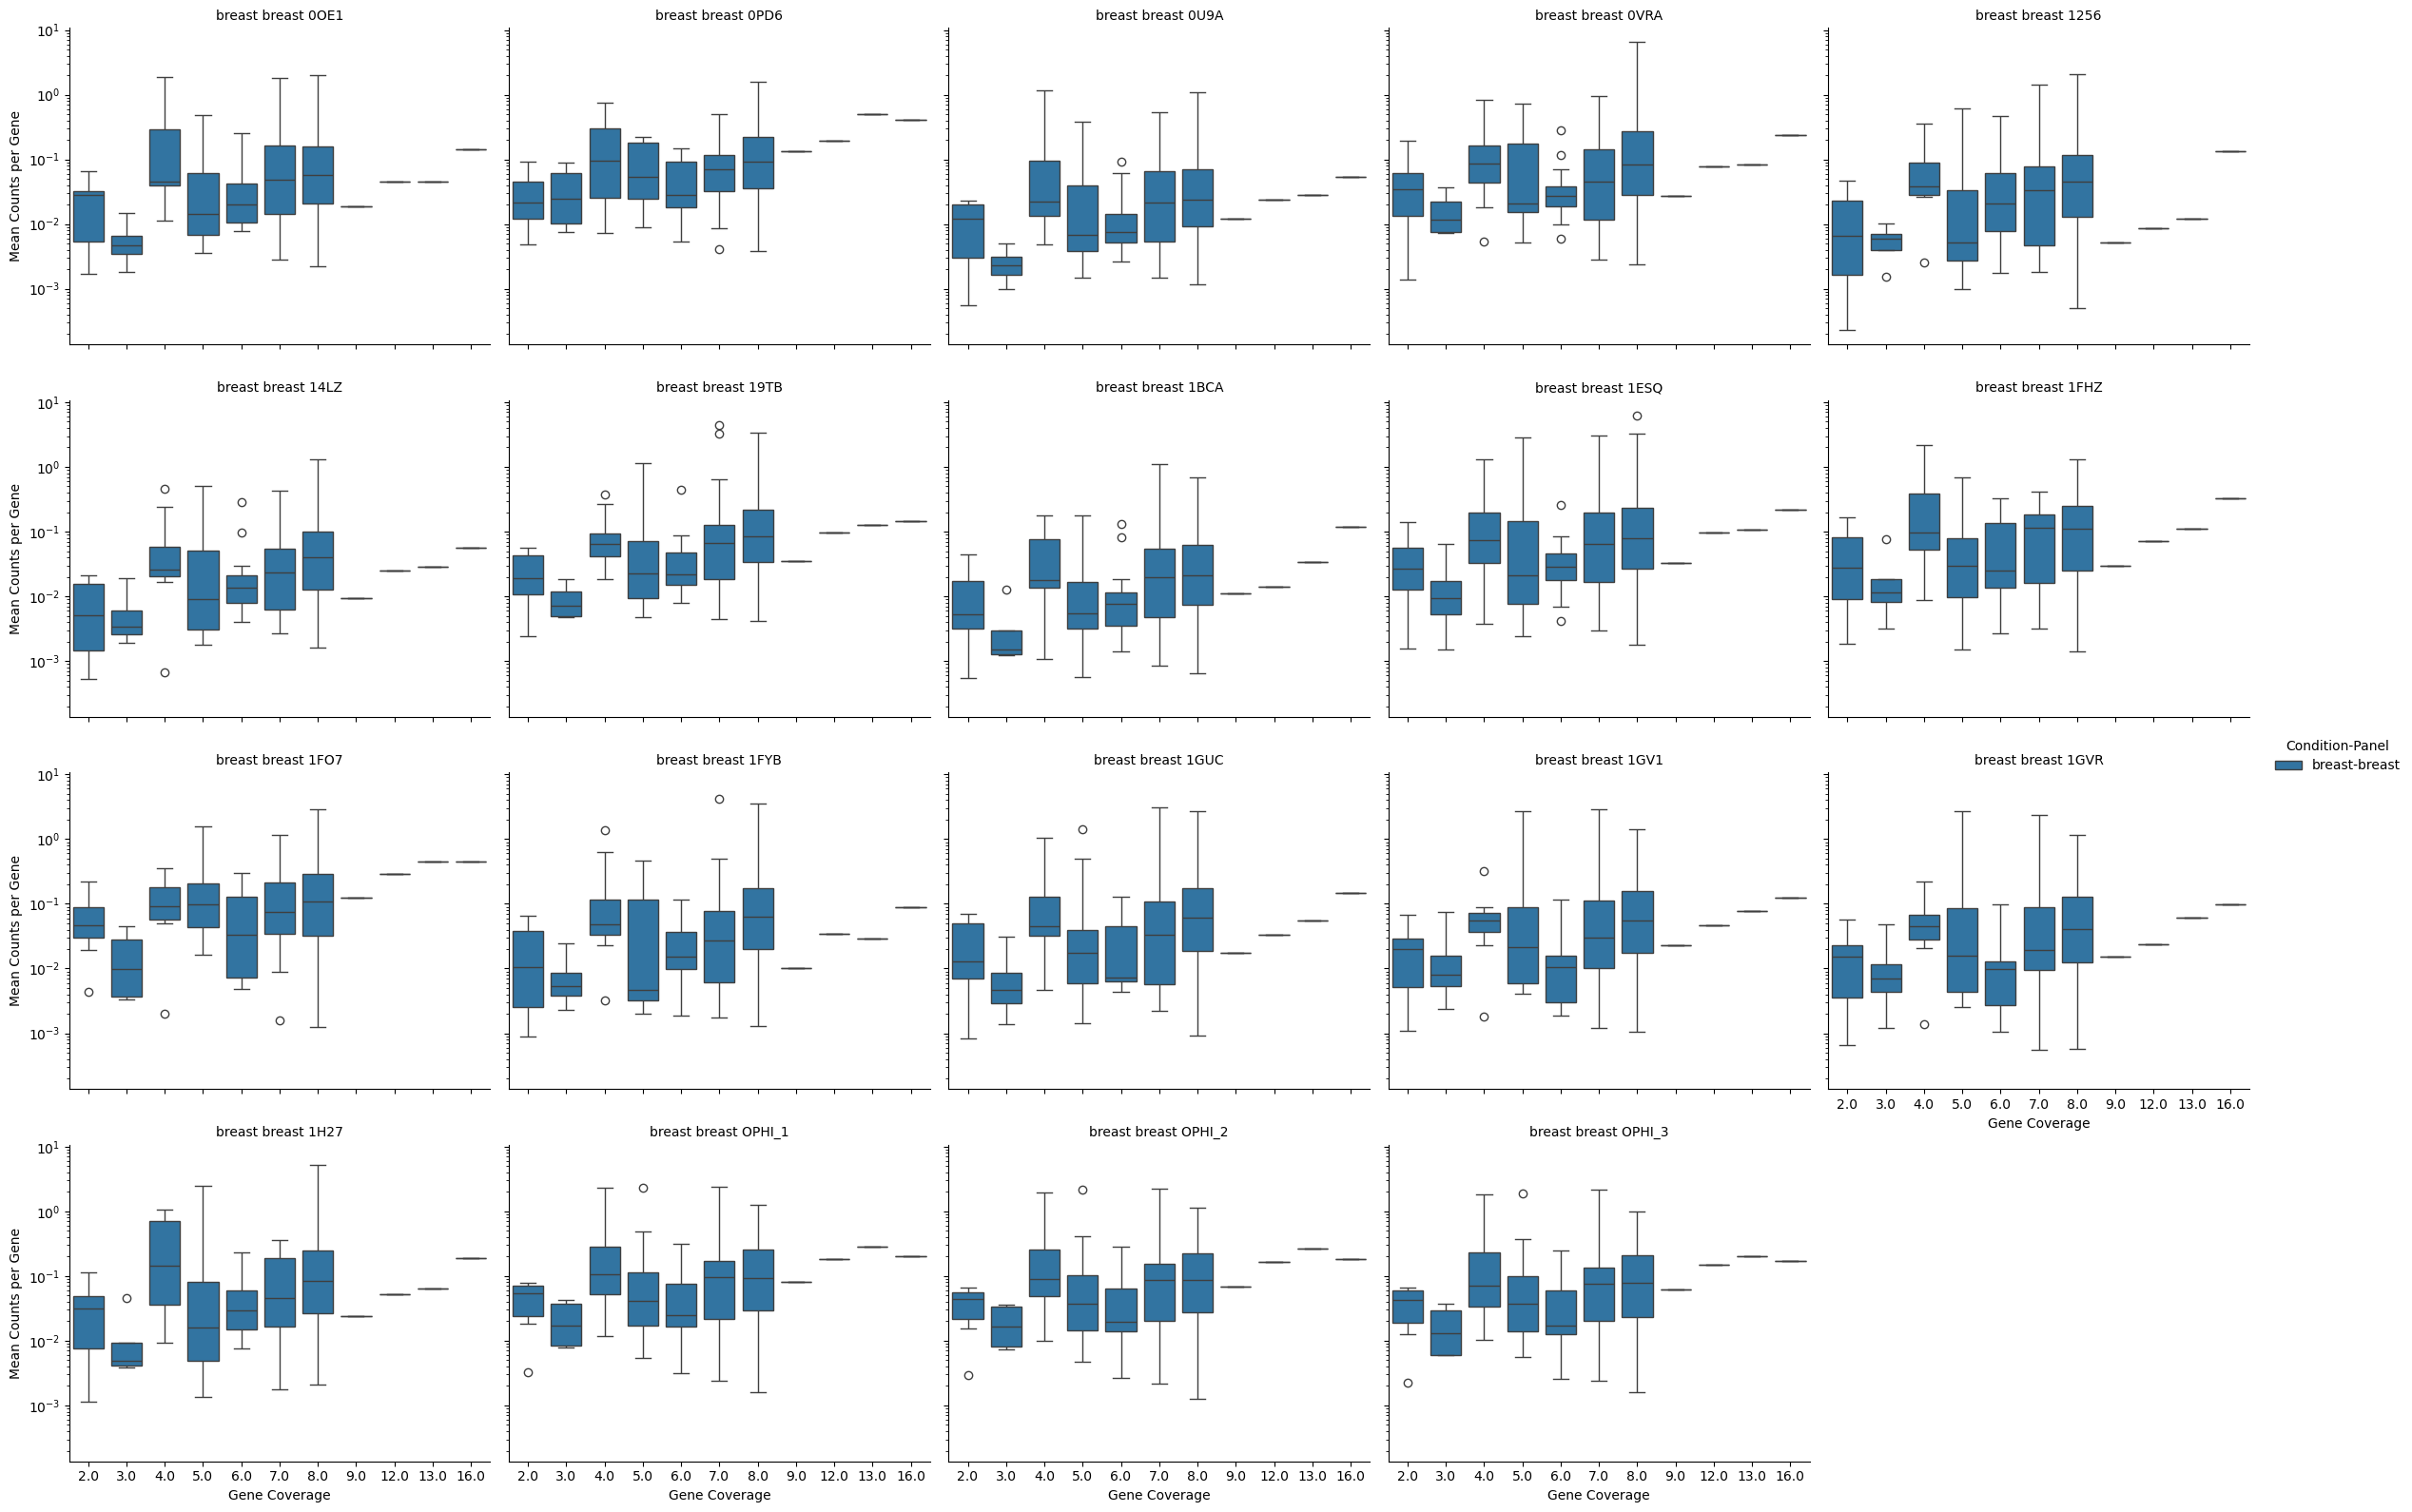

In [10]:
ref_segmentation = '10x_0um'

# merge ads and probe info
df = {}
for k,ad in ads.items():
    df_ = pd.DataFrame()

    condition, panel = k[1:3]
    df_['gene_coverage']= (gene_panels_info[condition, panel] 
        .set_index('name')['gene_coverage'] 
        .loc[ad.var_names])
    df_['mean_counts_per_gene'] = ad.X.mean(0).A1
    df_['name'] = ad.var_names

    df[k] = df_

df = pd.concat(df).reset_index()
df.columns = xenium_levels + tuple(df.columns[len(xenium_levels):])
df['condition_panel'] = df[['condition','panel']].agg('-'.join, axis=1)
df['condition_panel_sample'] = df[['condition','panel','sample']].agg(' '.join, axis=1)
df_seg = df[df['segmentation']==ref_segmentation]


# Create a FacetGrid to make subplots for each sample
palette = dict(zip(df_seg['condition_panel'].unique(),sns.color_palette('tab10'))) 
g = sns.FacetGrid(df_seg, col="condition_panel_sample", height=4, aspect=1.2, sharex=True, sharey=True, col_wrap=5)
g.map_dataframe(sns.boxplot, x='gene_coverage', y='mean_counts_per_gene', hue='condition_panel',palette=palette, log_scale=True)
g.add_legend(title="Condition-Panel")
g.set_axis_labels("Gene Coverage", "Mean Counts per Gene")
g.set_titles("{col_name}")
# plt.subplots_adjust(top=0.85)
# g.fig.suptitle('Mean Counts per Gene vs Gene Coverage by Sample')
plt.show()

## scRNA n° probes vs mean expr

In [ ]:
scrna_probe_path = '../../../data/markers/Chromium_Human_Transcriptome_Probe_Set_v1.1.0_GRCh38-2024-A.csv'
scrna_gene_panel_info = pd.read_csv(scrna_probe_path,skiprows=5)
scrna_gene_coverage = scrna_gene_panel_info['gene_name'].value_counts()

# p =  '../../../data/markers/Chromium_Human_Transcriptome_Probe_Set_v1.1.0_GRCh38-2024-A.probe_metadata.tsv'
# gene_panel_metadata = pd.read_csv(p,sep='\t')

seurat_to_h5_dir = Path(cfg['results_dir']) / 'seurat_to_h5'

ads_sc = {}
for dir in seurat_to_h5_dir.iterdir():
    if dir.is_dir():
        ads_sc[dir.name] = sc.read_10x_h5(dir / 'RNA_counts.h5')

In [ ]:
# merge ads and probe info
df = {}
for k,ad in ads_sc.items():
    df_ = pd.DataFrame()
    
    genes_found = [ g for g in ad.var_names if g in scrna_gene_coverage.index ]
    df_['gene_coverage']= scrna_gene_coverage.loc[genes_found]
    df_['mean_counts_per_gene'] = ad[:,genes_found].X.mean(0).A1
    df_['name'] = genes_found

    df[k] = df_

df = pd.concat(df).reset_index()
df.columns = ('reference',) + tuple(df.columns[1:])

# Create a FacetGrid to make subplots for each sample
palette = dict(zip(df['reference'].unique(),sns.color_palette('tab10'))) 
g = sns.FacetGrid(df, col="reference", height=4, aspect=1.2, sharex=True, sharey=True, col_wrap=3)
g.map_dataframe(sns.boxplot, x='gene_coverage', y='mean_counts_per_gene', hue='reference',palette=palette, log_scale=True)
g.add_legend(title="reference")
g.set_axis_labels("Gene Coverage", "Mean Counts per Gene")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('scRNA probes gene coverage')
plt.show()

In [ ]:
for condition_panel in u_condition_panel:
    condition, panel = condition_panel[1:3]

    # merge ads and probe info
    df = {}
    for k,ad in ads_sc.items():
        df_ = pd.DataFrame()
        gene_coverage_ = gene_panels_info[condition,panel].set_index('name')['gene_coverage'] 

        genes_found = [ g for g in ad.var_names if g in gene_coverage_.index ]
        df_['gene_coverage'] = (gene_coverage_.loc[genes_found])
        df_['mean_counts_per_gene'] = ad[:,genes_found].X.mean(0).A1
        # df_['name'] = genes_found

        df[k] = df_

    df = pd.concat(df).reset_index()
    df.columns = ('reference',) + tuple(df.columns[1:])

    # Create a FacetGrid to make subplots for each sample
    palette = dict(zip(df['reference'].unique(),sns.color_palette('tab10'))) 
    g = sns.FacetGrid(df, col="reference", height=4, aspect=1.2, sharex=True, sharey=True, col_wrap=3)
    g.map_dataframe(sns.boxplot, x='gene_coverage', y='mean_counts_per_gene', hue='reference',palette=palette, log_scale=True)
    g.add_legend(title="reference")
    g.set_axis_labels("Gene Coverage", "Mean Counts per Gene")
    g.set_titles("{col_name}")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'{condition} {panel} gene coverage')
    plt.show()

## scRNA vs Xenium

In [ ]:
df_sc_means = {}
for k_sc,ad_sc in ads_sc.items():
    df_sc_means[k_sc] = pd.Series(ad_sc.X.mean(0).A1,index = ad_sc.var_names)

# merge ads and probe info
df = {}
for k,ad in ads.items():
    df_ = pd.DataFrame()

    condition, panel = k[1:3]
    df_['gene_coverage']= (gene_panels_info[condition, panel] 
        .set_index('name')['gene_coverage'] 
        .loc[ad.var_names])
    df_['mean_counts_per_gene'] = ad.X.mean(0).A1
    df_['name'] = ad.var_names

    for k_sc,df_sc_ in df_sc_means.items():
        genes_found = [g for g in ad.var_names if g in df_sc_.index]
        df_[f'mean_counts_per_gene_{k_sc}'] = df_sc_.loc[genes_found]

    df[k] = df_

df = pd.concat(df).reset_index()
df.columns = xenium_levels + tuple(df.columns[len(xenium_levels):])
df['condition_panel'] = df[['condition','panel']].agg('-'.join, axis=1)
df['condition_panel_sample'] = df[['condition','panel','sample']].agg(' '.join, axis=1)
df['gene_coverage'] = df['gene_coverage'].astype(float)
df_seg = df[df['segmentation']=='10x_0um']

In [ ]:
for k_sc in ads_sc.keys():
    g = sns.lmplot(df_seg, 
        col="condition_panel_sample",  x='mean_counts_per_gene', y=f'mean_counts_per_gene_{k_sc}', 
        hue='gene_coverage', palette='viridis', 
        height=5, aspect=1.2, col_wrap=5, fit_reg=False,
        scatter_kws=dict(s=6, alpha=.5),
        facet_kws=dict(sharex=True, sharey=True), 
    )

    axes = g.fig.axes
    for ax in axes:
        diagonal_line(ax)

    g.set(xscale="log", yscale="log")
    g.set_axis_labels("Mean Counts per Gene Xenium", "Mean Counts per Gene scRNA")
    g.set_titles("{col_name}")
    plt.subplots_adjust(top=0.95)
    g.fig.suptitle(k_sc)
    plt.show()

## scRNA vs Xenium common genes

In [ ]:
panels_genes = [ad.var_names for ad in ads.values]
common_genes = list(set.intersection(*map(set, panels_genes)))
df_common_genes = df_seg[df_seg['name'].isin(common_genes)]

for k_sc in ads_sc.keys():
    g = sns.lmplot(df_common_genes, 
        col="condition_panel_sample",  x='mean_counts_per_gene', y=f'mean_counts_per_gene_{k_sc}', 
        hue='gene_coverage', palette='viridis', 
        height=5, aspect=1.2, col_wrap=5, fit_reg=False,
        scatter_kws=dict(s=20, alpha=.5),
        facet_kws=dict(sharex=True, sharey=True), 
    )

    axes = g.fig.axes
    for ax in axes:
        diagonal_line(ax)

    g.set(xscale="log", yscale="log")
    g.set_axis_labels("Mean Counts per Gene Xenium", "Mean Counts per Gene scRNA")
    g.set_titles("{col_name}")
    plt.subplots_adjust(top=0.95)
    g.fig.suptitle(k_sc)
    plt.show()
    break

## scRNA vs Xenium common genes except breast

In [ ]:
panels_genes = [ad.var_names for k,ad in ads.items() if 'breast' not in k]
common_genes = list(set.intersection(*map(set, panels_genes)))
df_common_genes = df_seg[df_seg['name'].isin(common_genes)]

for k_sc in ads_sc.keys():
    g = sns.lmplot(df_common_genes, 
        col="condition_panel_sample",  x='mean_counts_per_gene', y=f'mean_counts_per_gene_{k_sc}', 
        hue='gene_coverage', palette='viridis', 
        height=5, aspect=1.2, col_wrap=5, fit_reg=False,
        scatter_kws=dict(s=20, alpha=.5),
        facet_kws=dict(sharex=True, sharey=True), 
    )

    axes = g.fig.axes
    for ax in axes:
        diagonal_line(ax)

    g.set(xscale="log", yscale="log")
    g.set_axis_labels("Mean Counts per Gene Xenium", "Mean Counts per Gene scRNA")
    g.set_titles("{col_name}")
    plt.subplots_adjust(top=0.95)
    g.fig.suptitle(k_sc)
    plt.show()
    break